In [2]:
import sys
sys.path.append('../src')

In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem(
    project='research',
    bucket='amrit-research-samples',
    token='/Users/amrit/Desktop/StanfordAI/.keys/service-account.json'
)

## Load All Samples from GCS

In [4]:
import os
import json
import tqdm

rows = []
for root, dirs, files in fs.walk('amrit-research-samples/'):
    for file in tqdm.tqdm(files):
        model = root.split('/')[-2]
        f = os.path.join(root, file)
        if not 'llama' in f.lower():
            continue
        contents = fs.cat(os.path.join(root, file)).decode('utf-8')
        lines = contents.strip('\n').split('\n')
        for line in lines:
            parsed_line = json.loads(line)
            parsed_line['model'] = model
            for key in parsed_line['pass_at_original']:
                parsed_line[f'pass_at_original_{key}'] = parsed_line['pass_at_original'][key]

            for key in parsed_line['pass_at_mutated']:
                parsed_line[f'pass_at_mutated_{key}'] = parsed_line['pass_at_mutated'][key]


            for key in parsed_line['pass_at_ratio']:
                parsed_line[f'{key}_ratio'] = parsed_line['pass_at_ratio'][key]

            rows.append(parsed_line)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 273/273 [00:00<00:00, 416077.40it/s]
0it [00:00, ?it/s]
100%|██████████| 370/370 [03:15<00:00,  1.89it/s]
0it [00:00, ?it/s]
100%|██████████| 337/337 [00:00<00:00, 229423.87it/s]
0it [00:00, ?it/s]
100%|██████████| 947/947 [06:45<00:00,  2.33it/s]


In [5]:
import pandas as pd
df = pd.DataFrame(rows)


In [6]:
from mutations import * 
from mutations.registry import MutationRegistry

def add_mutation_type(row):
    mutation = row['mutation']
    for key in MutationRegistry._registry.keys():
        registry_vals = MutationRegistry.get(category=key)
        registry_vals_name = [v.__name__ for v in registry_vals]
        if mutation in registry_vals_name:
            row['mutation_type'] = key.name
            break
    return row

df = df.apply(add_mutation_type, axis=1)

2024-06-08 00:16:30.382 | INFO     | mutations.registry:register:24 - Registered Mutation LenToGeneratorTransformer to category CRT.arrays
2024-06-08 00:16:30.383 | INFO     | mutations.registry:register:24 - Registered Mutation ListInitializerUnpackTransformer to category CRT.arrays
2024-06-08 00:16:30.384 | INFO     | mutations.registry:register:24 - Registered Mutation NestedArrayInitializerTransformer to category CRT.arrays
2024-06-08 00:16:30.385 | INFO     | mutations.registry:register:24 - Registered Mutation ReverseIterationTransformer to category CRT.arrays
2024-06-08 00:16:30.386 | INFO     | mutations.registry:register:24 - Registered Mutation SingleElementInitializerTransformer to category CRT.arrays
2024-06-08 00:16:30.387 | INFO     | mutations.registry:register:24 - Registered Mutation StringToCharArrayTransformer to category CRT.arrays
2024-06-08 00:16:30.388 | WARNING  | mutations.registry:__new__:50 - BooleanDemorgansTransformer mutation is disabled.
2024-06-08 00:16:

In [7]:
df.to_csv('results.csv')

# Mutations by Type

In [8]:
df.groupby('mutation_type').size()

mutation_type
arrays           25
booleans        198
code_style      619
conditionals     47
dicts             5
loops            19
math             24
numbers         368
strings          12
dtype: int64

## Mutations by Model

In [11]:
counts = df.groupby('model')['mutation'].agg('count')
counts

model
Qwen_CodeQwen1.5-7B-Chat                    273
codellama_CodeLlama-7b-Instruct-hf          370
deepseek-ai_deepseek-coder-1.3b-instruct    337
meta-llama_Meta-Llama-3-8B-Instruct         947
Name: mutation, dtype: int64

## Average Cross Levenshtein Distance by Mutation Type

In [9]:
metric = 'pass@1_ratio'
mean_by_mutation_model = df.groupby(['mutation', 'model'])[metric].median().reset_index()
mean_by_mutation_model['pass@1_ratio'] = mean_by_mutation_model[metric].clip(0, 3)
pivot_df = mean_by_mutation_model.pivot(index='mutation', columns='model', values=metric)


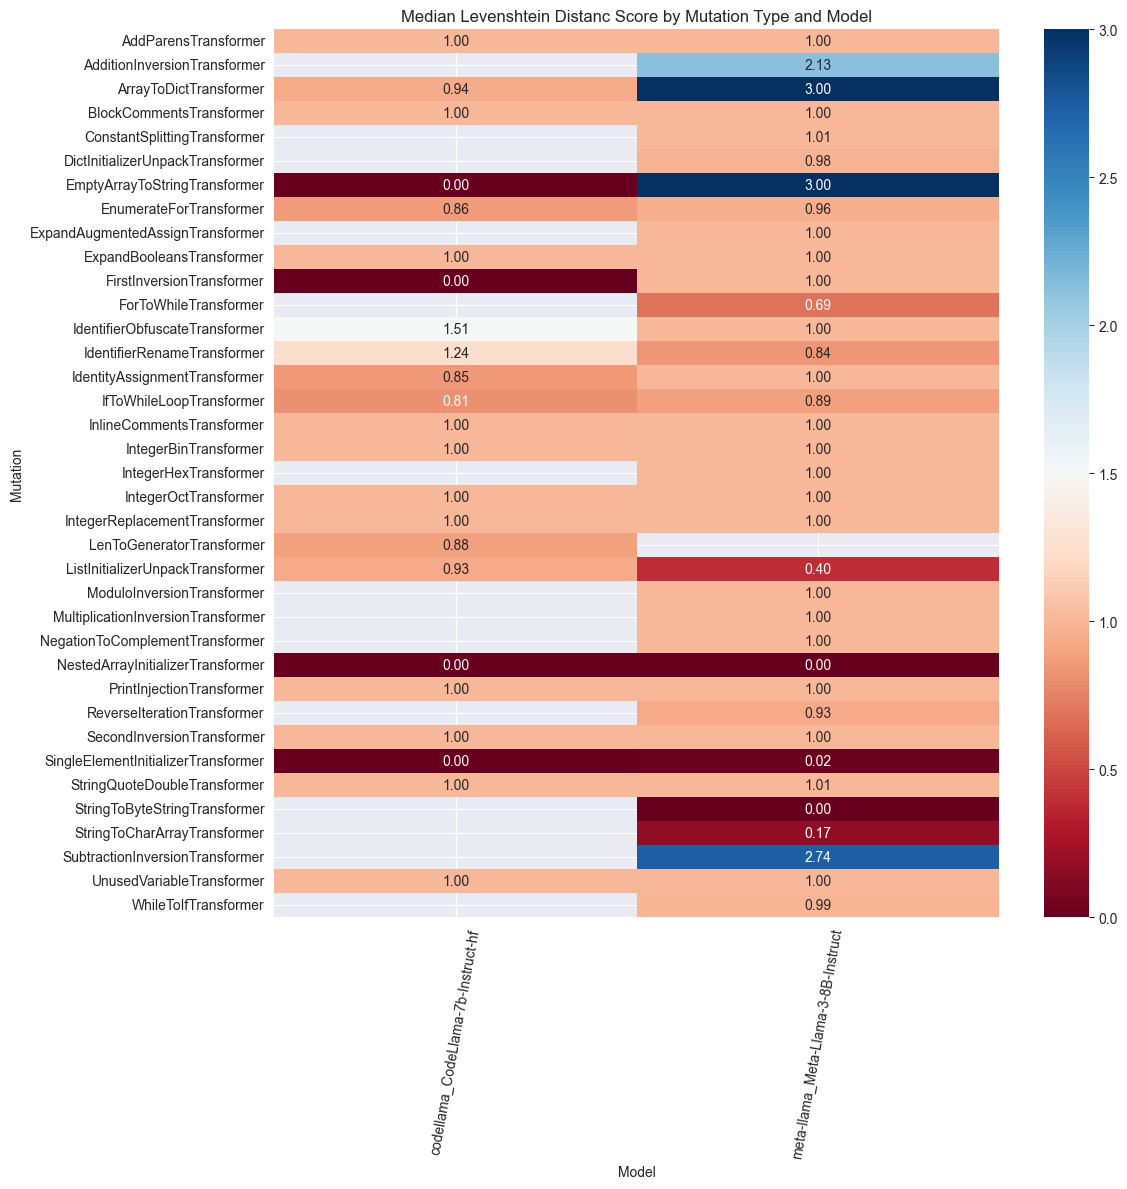

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="RdBu", cbar=True)
plt.title('Median Levenshtein Distanc Score by Mutation Type and Model')
plt.xlabel('Model')
plt.ylabel('Mutation')
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()

In [11]:
!pip install seaborn

In [16]:
import json
with open('/Users/amrit/Downloads/codellama_CodeLlama-7b-Instruct-hf_HumanEval_124_IdentifierObfuscateTransformer_0.jsonl', 'r') as f:
    f_p = json.loads(f.read())

{'problem_id': 'HumanEval/124', 'mutation': 'IdentifierObfuscateTransformer', 'mutation_id': '14', 'stem_id': '0', 'original_prefix': 'def valid_date(date):\n    """You have to write a function which validates a given date string and\n    returns True if the date is valid otherwise False.\n    The date is valid if all of the following rules are satisfied:\n    1. The date string is not empty.\n    2. The number of days is not less than 1 or higher than 31 days for months 1,3,5,7,8,10,12. And the number of days is not less than 1 or higher than 30 days for months 4,6,9,11. And, the number of days is not less than 1 or higher than 29 for the month 2.\n    3. The months should not be less than 1 or higher than 12.\n    4. The date should be in the format: mm-dd-yyyy\n    for example:\n    valid_date(\'03-11-2000\') => True\n    valid_date(\'15-01-2012\') => False\n    valid_date(\'04-0-2040\') => False\n    valid_date(\'06-04-2020\') => True\n    valid_date(\'06/04/2020\') => False\n    "

In [18]:
for sample in f_p['examples']['passed']['original']:
    print(sample)
    print('===')

def valid_date(date):
    """You have to write a function which validates a given date string and
    returns True if the date is valid otherwise False.
    The date is valid if all of the following rules are satisfied:
    1. The date string is not empty.
    2. The number of days is not less than 1 or higher than 31 days for months 1,3,5,7,8,10,12. And the number of days is not less than 1 or higher than 30 days for months 4,6,9,11. And, the number of days is not less than 1 or higher than 29 for the month 2.
    3. The months should not be less than 1 or higher than 12.
    4. The date should be in the format: mm-dd-yyyy
    for example:
    valid_date('03-11-2000') => True
    valid_date('15-01-2012') => False
    valid_date('04-0-2040') => False
    valid_date('06-04-2020') => True
    valid_date('06/04/2020') => False
    """
    if not date:
        return False
    date_parts = date.split('-')
    if len(date_parts) != 3:
        return False
    (month, day, year) = date_parts

In [19]:
for sample in f_p['examples']['passed']['mutated']:
    print(sample)
    print('===')

def valid_date(date):
    """You have to write a function which validates a given date string and
    returns True if the date is valid otherwise False.
    The date is valid if all of the following rules are satisfied:
    1. The date string is not empty.
    2. The number of days is not less than 1 or higher than 31 days for months 1,3,5,7,8,10,12. And the number of days is not less than 1 or higher than 30 days for months 4,6,9,11. And, the number of days is not less than 1 or higher than 29 for the month 2.
    3. The months should not be less than 1 or higher than 12.
    4. The date should be in the format: mm-dd-yyyy
    for example:
    valid_date('03-11-2000') => True
    valid_date('15-01-2012') => False
    valid_date('04-0-2040') => False
    valid_date('06-04-2020') => True
    valid_date('06/04/2020') => False
    """
    if not date:
        return False
    date_parts = date.split('-')
    if len(date_parts) != 3:
        return False
    (month, day, year) = date_parts